In [ ]:
%run init_notebook.py
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from src.models import VAE
from src.utils.logger import save_training_results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_model_path = r'C:\Users\Articuno\Desktop\TFG-info\data\models\mnist.pth'
mnist_datasets_path = r'C:\Users\Articuno\Desktop\TFG-info\data\mnist'

In [2]:
batch_size = 128

train_ds = FashionMNIST(root=mnist_datasets_path, train=True,  download=True, transform=ToTensor())
valid_ds = FashionMNIST(root=mnist_datasets_path, train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
input_size = (28, 28)
latent_dim = 20
channels   = [1, 32, 32, 64]

model = VAE(input_size, latent_dim, channels=channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# early‐stop / logging
best_val = float('inf')
hist = {'train':[], 'valid':[], 'kl':[], 'recon':[]}

Model:
 VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=1024, out_features=20, bias=True)
    (fc2): Linear(in_features=1024, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=20, out_features=1024, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 4, 4))
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): ConvTranspose

In [4]:
num_epochs = 15

for epoch in range(1, num_epochs+1):
    # Training
    model.train()
    train_loss = 0.0
    for x,_ in train_loader:
        x = x.to(device)               # [B,1,28,28]
        optimizer.zero_grad()
        recon_term, kld = model(x)
        loss = model.loss_function(recon_term, kld, beta=1.0)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for x,_ in valid_loader:
            x = x.to(device)
            recon_term, kld = model(x)
            valid_loss += model.loss_function(recon_term, kld, beta=1.0).item() * x.size(0)
    valid_loss /= len(valid_loader.dataset)

    scheduler.step(valid_loss)

    # Book keeping
    hist['train'].append(train_loss)
    hist['valid'].append(valid_loss)
    print(f"Epoch {epoch:2d}  train={train_loss:.4f}  valid={valid_loss:.4f}")
    
    if valid_loss < best_val:
        best_val = valid_loss
        torch.save(model.state_dict(), mnist_model_path)

Epoch  1  train=53.1928  valid=40.1953
Epoch  2  train=39.2868  valid=38.7848
Epoch  3  train=38.4058  valid=38.1877
Epoch  4  train=37.9528  valid=37.9315
Epoch  5  train=37.6624  valid=37.6770
Epoch  6  train=37.3896  valid=37.4437
Epoch  7  train=37.2345  valid=37.3696
Epoch  8  train=37.0626  valid=37.1415
Epoch  9  train=36.9212  valid=36.9871
Epoch 10  train=36.8579  valid=36.8529
Epoch 11  train=36.7473  valid=36.8132
Epoch 12  train=36.6798  valid=36.7315
Epoch 13  train=36.5597  valid=36.6577
Epoch 14  train=36.5244  valid=36.6968
Epoch 15  train=36.4460  valid=36.5431


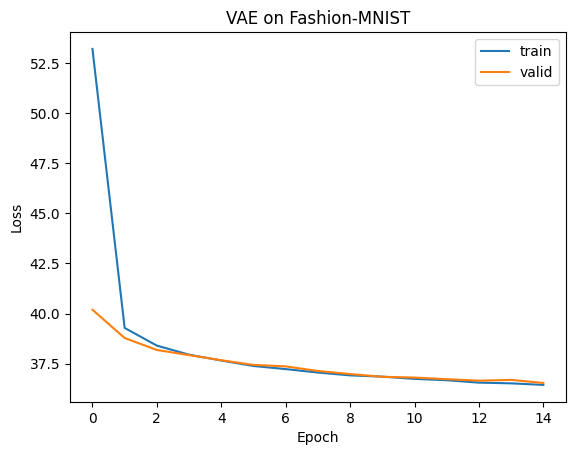

In [5]:
import numpy as np

plt.plot(hist['train'], label='train')
plt.plot(hist['valid'], label='valid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE on Fashion-MNIST")
plt.show()

save_training_results({
    "train_losses": hist['train'],
    "valid_losses": hist['valid'],
    "num_epochs": num_epochs,
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "latent_dim": latent_dim,
    "channels": channels,
}, "mnist_vae.json")

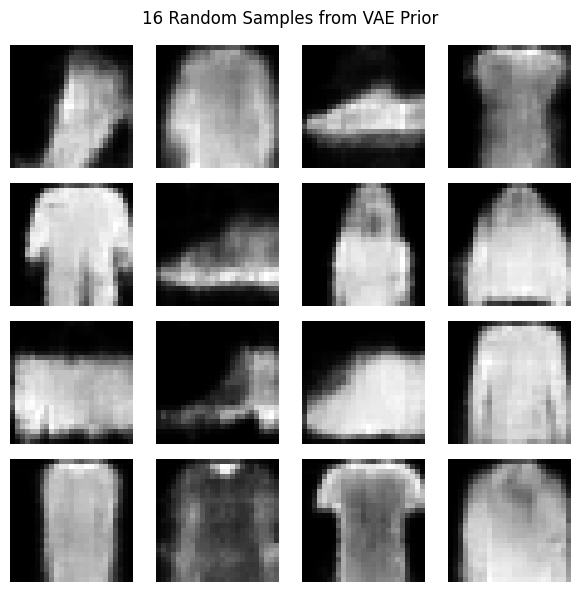

In [6]:
model.load_state_dict(torch.load(mnist_model_path))
model.eval()

N = 16 # should be a square number.

with torch.no_grad():
    # sample N independent latents
    z = torch.randn(N, latent_dim, device=device)
    x_gen = model.decoder(z).clamp(0,1).cpu()  # [N,1,28,28]

# plot 4×4 grid of random samples
fig, axes = plt.subplots(4,4, figsize=(6,6))
for idx,ax in enumerate(axes.flatten()):
    ax.imshow(x_gen[idx,0], cmap="gray")
    ax.axis("off")
plt.suptitle(f"{N} Random Samples from VAE Prior")
plt.tight_layout()
plt.show()

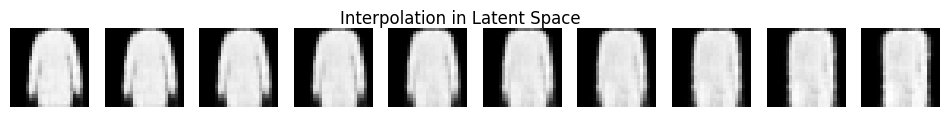

In [7]:
model.eval()

# pick two random endpoints in latent space
z_start = torch.randn(latent_dim, device=device)
z_end   = torch.randn(latent_dim, device=device)
n_steps = 10

# linearly interpolate between them
z_interp = torch.stack([
    z_start * (1 - t) + z_end * t
    for t in torch.linspace(0, 1, n_steps)
], dim=0)  # [n_steps, latent_dim]

with torch.no_grad():
    x_interp = model.decoder(z_interp).clamp(0,1).cpu()  # [n_steps,1,28,28]

# plot as a row of n_steps images
fig, axes = plt.subplots(1, n_steps, figsize=(n_steps*1.2,1.2))
for i,ax in enumerate(axes):
    ax.imshow(x_interp[i,0], cmap="gray")
    ax.axis("off")
plt.suptitle("Interpolation in Latent Space")
plt.show()